In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt


In [9]:
data1 = pd.read_csv('/kaggle/input/ue22am343ab4-hackathon-2024/train.csv')
data1.head()

,id,Date,#Passengers,Temperature,Average_Fuel_Price,Ticket_Price,Delay_Category
0,1,31-01-1949,135,31.56,5.62,378.61,Long Delay
1,2,28-02-1949,132,40.32,5.67,440.64,Short Delay
2,3,31-03-1949,132,39.26,5.93,446.10,Short Delay
3,4,30-04-1949,133,56.09,5.95,450.02,On Time
4,5,31-05-1949,140,74.99,6.03,418.83,Short Delay


In [10]:
data =  data1[['Date' , '#Passengers']]

In [11]:
data.shape

(593, 2)

In [12]:
data.columns

Index(['Date', '#Passengers'], dtype='object')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         593 non-null    object
 1   #Passengers  593 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.4+ KB


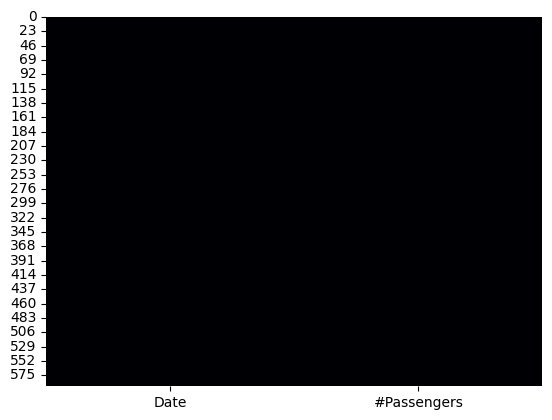

In [14]:
sns.heatmap(data.isnull(),cmap = 'magma',cbar = False);

In [15]:
data.describe()

,#Passengers
count,593.00
mean,324.78
std,170.91
min,92.00
25%,183.00
50%,285.00
75%,433.00
max,839.00


In [16]:
data = data.rename(columns = {'#Passengers':'Passengers'})
data.head()

,Date,Passengers
0,31-01-1949,135
1,28-02-1949,132
2,31-03-1949,132
3,30-04-1949,133
4,31-05-1949,140


In [17]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [18]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

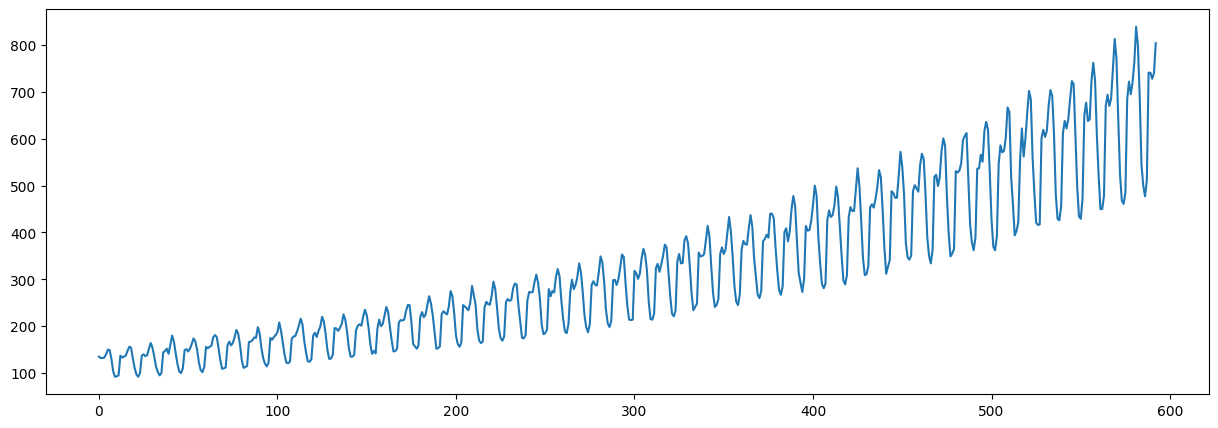

In [19]:
plt.figure(figsize = (15,5))
data['Passengers'].plot();

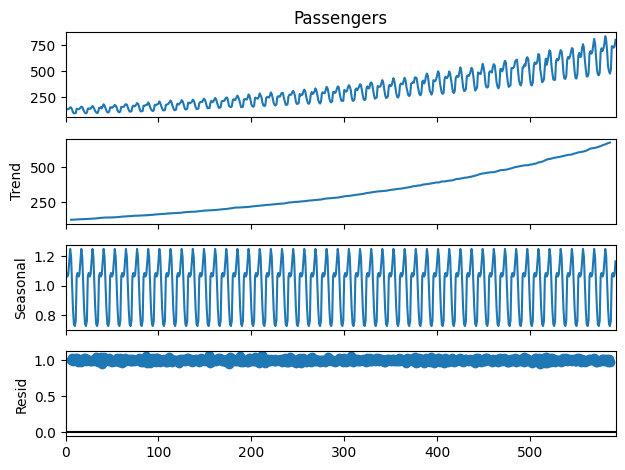

In [20]:
dec = sm.tsa.seasonal_decompose(data['Passengers'],period = 12, model = 'multiplicative').plot()
plt.show()

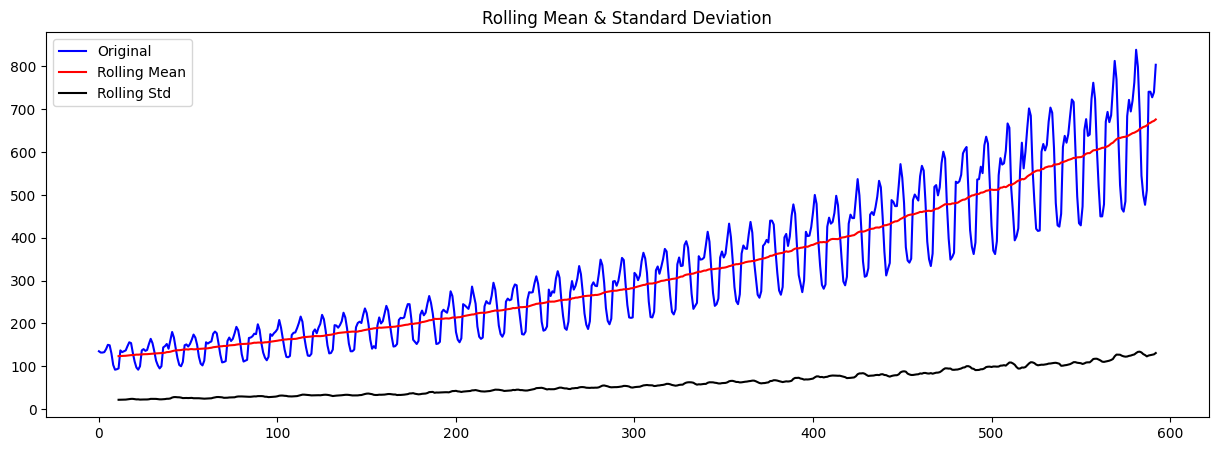

Results of Dickey-Fuller Test:
Test Statistic                  8.15
p-value                         1.00
#Lags Used                     17.00
Number of Observations Used   575.00
Critical Value (1%)            -3.44
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


In [21]:
test_stationarity(data['Passengers'])

In [22]:
data_diff = data['Passengers'].diff()
data_diff = data_diff.dropna()


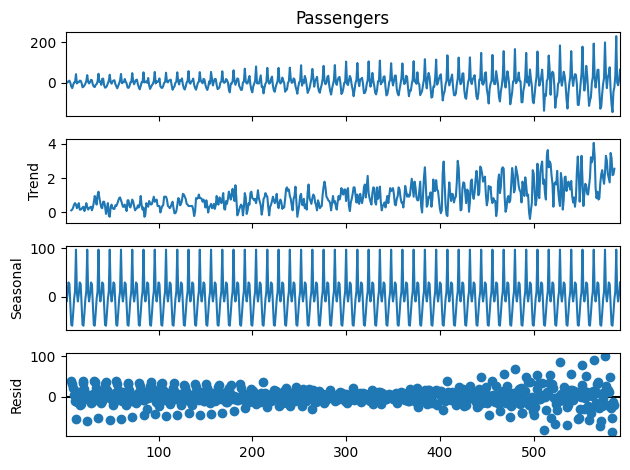

In [23]:
dec = sm.tsa.seasonal_decompose(data_diff, period=12).plot()
plt.show()


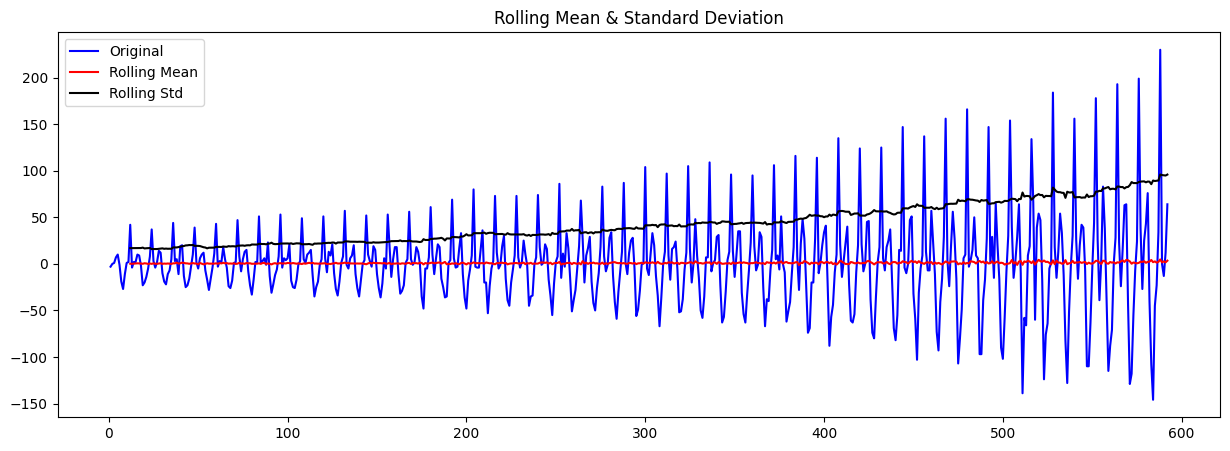

Results of Dickey-Fuller Test:
Test Statistic                 -3.23
p-value                         0.02
#Lags Used                     19.00
Number of Observations Used   572.00
Critical Value (1%)            -3.44
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


In [24]:
test_stationarity(data_diff)

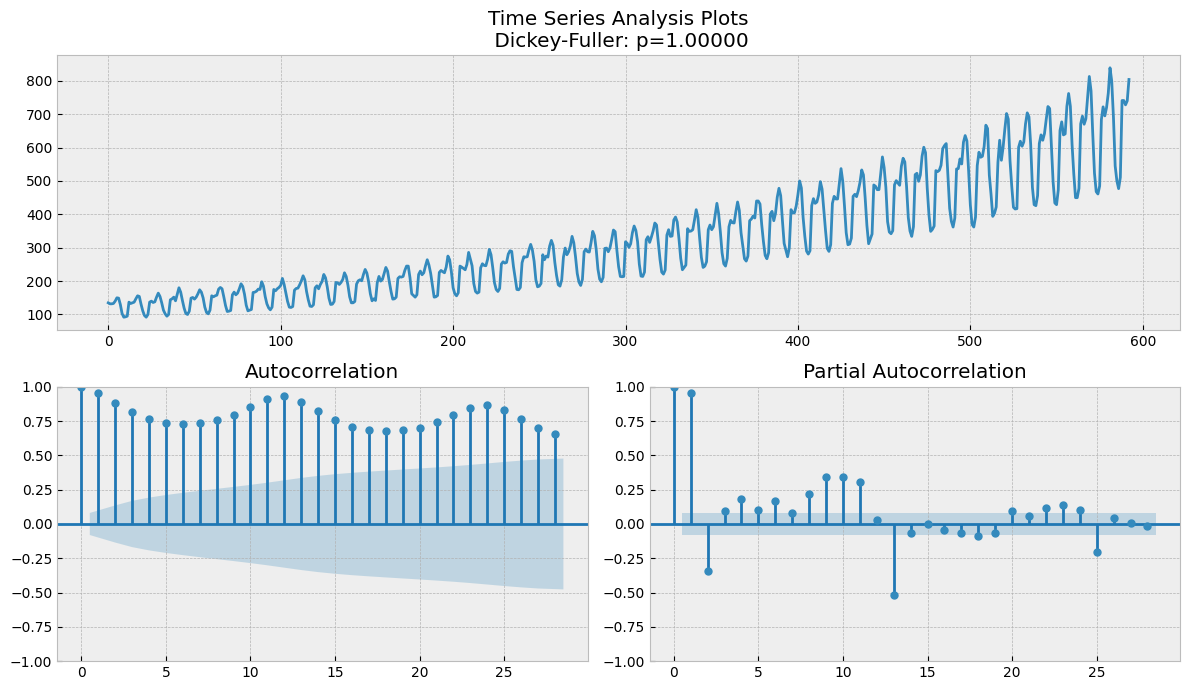

In [25]:
tsplot(data['Passengers'])

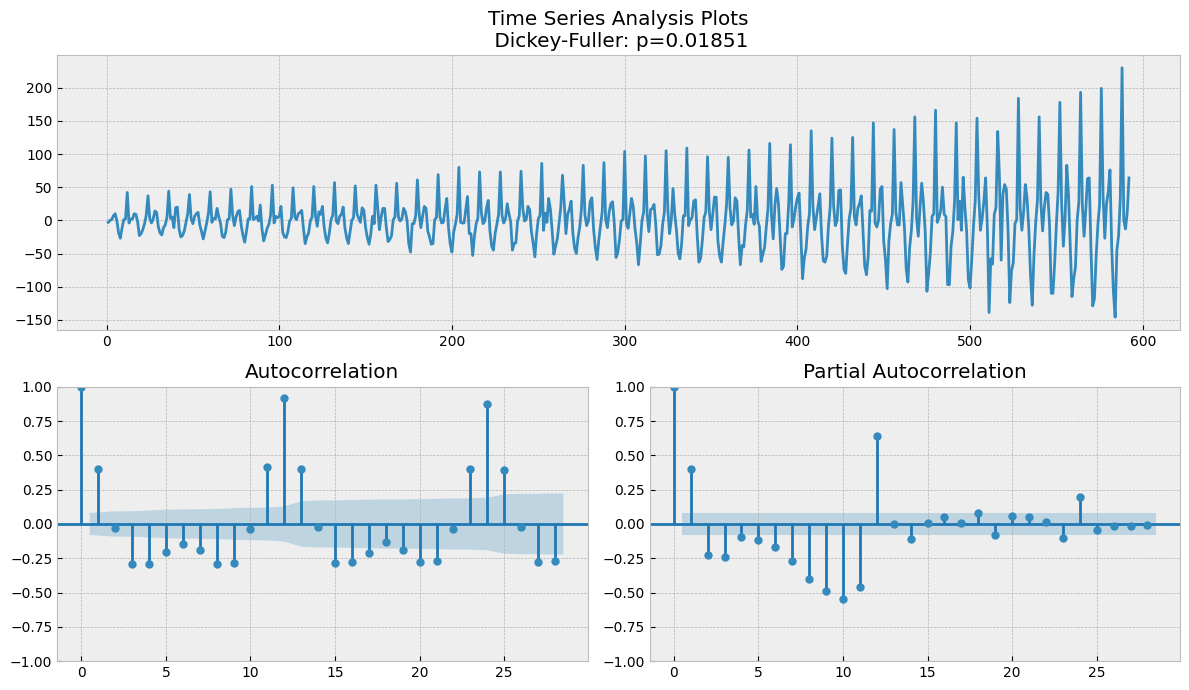

In [26]:
tsplot(data_diff)

In [27]:
from statsmodels.tsa.arima.model import ARIMA

# Create and fit the ARIMA model
model = ARIMA(data['Passengers'], order=(1, 1, 1))
model_fit = model.fit()

# Print the summary of the fitted model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  593
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3053.033
Date:                Thu, 07 Nov 2024   AIC                           6112.065
Time:                        05:02:03   BIC                           6125.216
Sample:                             0   HQIC                          6117.187
                                - 593                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2039      0.125      1.627      0.104      -0.042       0.450
ma.L1          0.2546      0.130      1.964      0.050       0.000       0.509
sigma2      1765.1937     59.423     29.706      0.0

In [28]:
size = int(len(data) - 30)
train, test = data['Passengers'][0:size], data['Passengers'][size:len(data)]

print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    # Use iloc to index by position, not index value
    obs = test.iloc[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))


	 ARIMA MODEL : In- Sample Forecasting 

predicted = 456.157045, expected = 478.000000
predicted = 489.390214, expected = 671.000000
predicted = 757.937793, expected = 694.000000
predicted = 684.550981, expected = 670.000000
predicted = 661.465825, expected = 686.000000
predicted = 695.266046, expected = 749.000000
predicted = 775.319872, expected = 813.000000
predicted = 835.801754, expected = 770.000000
predicted = 745.051656, expected = 641.000000
predicted = 588.139992, expected = 523.000000
predicted = 481.218591, expected = 468.000000
predicted = 452.565916, expected = 461.000000
predicted = 461.516388, expected = 485.000000
predicted = 496.091377, expected = 684.000000
predicted = 775.184724, expected = 722.000000
predicted = 717.680773, expected = 695.000000
predicted = 683.707672, expected = 720.000000
predicted = 734.376039, expected = 763.000000
predicted = 779.249383, expected = 839.000000
predicted = 870.204138, expected = 799.000000
predicted = 772.809740, expected = 691.

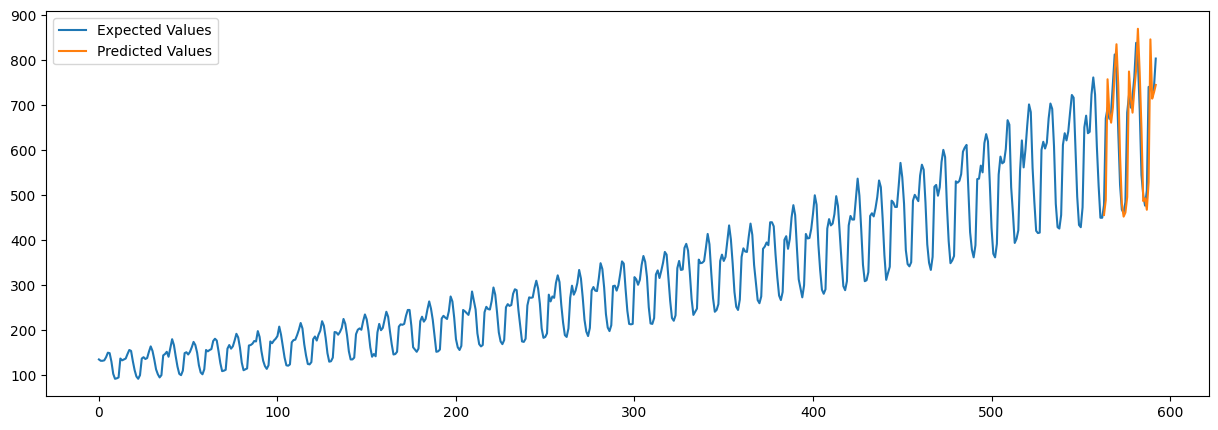

In [29]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(data['Passengers'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [30]:
from sklearn.metrics import mean_absolute_error

# Calculate Mean Absolute Error
mae = mean_absolute_error(test, predictions)

# Print MAE
print('Test MAE: %.4f' % mae)


Test MAE: 59.8384


In [31]:
error = np.sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.4f' % error)


Test RMSE: 79.9032


In [32]:
# Import necessary libraries
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Load the dataset
train_df = pd.read_csv('/kaggle/input/ue22am343ab4-hackathon-2024/train.csv')

# Feature selection
X = train_df[['Temperature', 'Average_Fuel_Price', 'Ticket_Price']]
y = train_df['Delay_Category']

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Set up the initial model
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss', random_state=42)

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Initialize GridSearchCV to search for the best parameters
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best estimator
best_xgb_clf = grid_search.best_estimator_

# Make predictions on the validation set
y_pred = best_xgb_clf.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Best Validation Accuracy after tuning: {accuracy * 100:.2f}%")

# Display best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)


Fitting 3 folds for each of 729 candidates, totalling 2187 fits


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Validation Accuracy after tuning: 67.23%
Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

# Load the dataset
train_df = pd.read_csv('/kaggle/input/ue22am343ab4-hackathon-2024/train.csv')

# Feature selection
X = train_df[['Temperature', 'Average_Fuel_Price', 'Ticket_Price']]
y = train_df['Delay_Category']

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Convert target to categorical format for classification
y_categorical = to_categorical(y_encoded)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_normalized, y_categorical, test_size=0.2, random_state=42)

# Step 2: Build an Optimized Deep Learning Model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.4))  # Adjusted dropout for regularization

model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(y_categorical.shape[1], activation='softmax'))  # Output layer with softmax for multi-class

# Compile the model with a lower learning rate and weight decay
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy after tuning: {val_accuracy * 100:.2f}%")

# Optionally, make predictions and calculate accuracy
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)
accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 403ms/step - accuracy: 0.2403 - loss: 2.0747 - val_accuracy: 0.3361 - val_loss: 1.4968
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2593 - loss: 1.8901 - val_accuracy: 0.3697 - val_loss: 1.4809
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3363 - loss: 1.7203 - val_accuracy: 0.4202 - val_loss: 1.4643
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4028 - loss: 1.5824 - val_accuracy: 0.4370 - val_loss: 1.4504
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4076 - loss: 1.4671 - val_accuracy: 0.4538 - val_loss: 1.4423
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4442 - loss: 1.4405 - val_accuracy: 0.4706 - val_loss: 1.4337
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4623 - loss: 1.4143 - val_accuracy: 0.4874 - val_loss: 1.4237
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4106 - loss: 1.4409 - val_accuracy: 0.4790 - val_loss: 

In [7]:
import pandas as pd
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Load test dataset
test_df = pd.read_csv('/kaggle/input/ue22am343ab4-hackathon-2024/test.csv')

# Generate passenger predictions using ARIMA model

# Prepare the submission DataFrame
submission_df = pd.DataFrame({
    'Date': test_df['Date'],  # Assuming 'Date' column is in test data
    '#Passengers': yhat,
    'Delay_Category': y_pred
})

# Save to CSV
submission_df.to_csv('/kaggle/working/submission.csv', index=False)
print("Submission file created: 'submission.csv'")


NameError: name 'y_pred' is not defined